# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [513]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [514]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [515]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score
from itertools import chain

In [516]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [517]:
# define a function to load json file to a dataframe
def load_json_dataframe(file_path):
  with open(file_path, 'r') as file:
    data = json.load(file)
  df = pd.DataFrame(data)
  return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [518]:
# read the json file by giving the file path and create a dataframe
file_path = '/content/ingredient_and_quantity.json'
df = load_json_dataframe(file_path)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [519]:
# display first five rows of the dataframe - df
display(df.head(5))

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [520]:
# print the dimensions of dataframe - df
print("Dataframe Dimensions:", df.shape)

Dataframe Dimensions: (285, 2)


In [521]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [522]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].str.split()
# Tokenize POS
df['pos_tokens'] = df['pos'].str.split()

In [523]:
# display first five rows of the dataframe - df
display(df.head(5))

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [524]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [525]:
# check for the equality of input_length and pos_length in the dataframe

# Check for inequality in lengths
mismatch_rows = df[df['input_length'] != df['pos_length']]

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [526]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(pos_lists):
    return sorted(set(label for sublist in pos_lists for label in sublist))

print("Unique POS labels in the dataset:", unique_labels(df['pos_tokens']))

Unique POS labels in the dataset: ['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>
<font color = red>The mismatch_rows DataFrame from
step 2.2.2 contain recipes where the number of tokens in the 'input' and 'pos' fields does not match. These recipes require cleaning or formatting or removal.</font> <br>
<font color = red>The unique_labels function from step 2.2.3 helps identify all unique POS labels used in the data. Examining these labels can provide insight into the data's structure and identify any unexpected labels.</font> <br>


In [527]:
# Display the rows with unequal lengths
print(f"Number of mismatched rows: {len(mismatch_rows)}")
display(mismatch_rows)

Number of mismatched rows: 5


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
17                                                                                                                                                                                                                                                   2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt                                                                                                                                                                                                                                                                                                                                                                                                                 quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                         [2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]                                                                                                                                                                                                                                                                                                                                                                                                                                                        [quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          14
27                                                                                   1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce                                                                                                                                                               quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient in

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [528]:
# drop the irrelevant recipe data

# drop unequal ones
# Drop rows with unequal input and pos lengths
df = df[df['input_length'] == df['pos_length']]

# Reset the index
df = df.reset_index(drop=True)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [529]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

print("Dataframe Dimensions:", df.shape)

Dataframe Dimensions: (280, 6)


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [530]:
# validate the input length and pos length as input_length and pos_length

# Check for unequal rows again
mismatch_rows = df[df['input_length'] != df['pos_length']]

# Display unequal rows (if any)
mismatch_rows
# No rows displayed shows no unequal rows in the dataframe

Empty DataFrame
Columns: [input, pos, input_tokens, pos_tokens, input_length, pos_length]
Index: []

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [531]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [532]:
# print the first five rows of train_df
print("Train Dataframe Dimensions:", train_df.shape)
display(train_df.head(5))

Train Dataframe Dimensions: (196, 6)


input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length
175                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
55   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ing

In [533]:
# print the first five rows of the val_df
print("Validation  Dataframe Dimensions:", val_df.shape)
val_df.head()

Validation  Dataframe Dimensions: (84, 6)


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
33                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15
108  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi P

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [534]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [535]:
# validate the shape of training and validation samples
print("X_train length:", len(X_train))
print("X_val length:", len(X_val))
print("y_train length:", len(y_train))
print("y_val length:", len(y_val))

X_train length: 196
X_val length: 84
y_train length: 196
y_val length: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [536]:
# Display the number of unique labels present in y_train

train_labels = sorted(set(label for sublist in y_train for label in sublist))
print("Unique labels in y_train:", train_labels)
print("Number of unique labels:", len(train_labels))

Unique labels in y_train: ['ingredient', 'quantity', 'unit']
Number of unique labels: 3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [537]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    """
    Flattens a nested list into a single list.

    Args:
        nested_list: The nested list to flatten.

    Returns:
        A flattened list.
    """
    return [item for sublist in nested_list for item in sublist]

In [538]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [539]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    """
    Extracts tokens and POS tags, validates their lengths, and displays samples.

    Args:
        df: The Pandas DataFrame containing the recipe data.
        dataset_name: The name of the dataset (Training or Validation).
    """
    all_input_tokens = flatten_list(df['input_tokens'].tolist())
    all_pos_tokens = flatten_list(df['pos_tokens'].tolist())

    # Validate lengths
    print(f"{dataset_name} Dataset:")
    print(f"Total number of input tokens: {len(all_input_tokens)}")
    print(f"Total number of POS tags: {len(all_pos_tokens)}")

    # Display first 10 records
    print("\nFirst 10 input tokens:", all_input_tokens[:10])
    print("First 10 POS tags:", all_pos_tokens[:10])
    return all_input_tokens, all_pos_tokens

In [540]:
# extract the tokens and its pos tags
flat_input_tokens, flat_pos_tokens  = extract_and_validate_tokens(train_df, dataset_name)

Training Dataset:
Total number of input tokens: 7114
Total number of POS tags: 7114

First 10 input tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 POS tags: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [541]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
    """
    Categorizes tokens into ingredients, units, and quantities.

    Args:
        tokens: The list of tokens.
        pos_tags: The list of corresponding POS tags.

    Returns:
        Lists of ingredients, units, and quantities.
    """
    ingredients = []
    units = []
    quantities = []

    for token, pos_tag in zip(tokens, pos_tags):
        if pos_tag == 'ingredient':
            ingredients.append(token)
        elif pos_tag == 'unit':
            units.append(token)
        elif pos_tag == 'quantity':
            quantities.append(token)

    return ingredients, units, quantities


In [542]:
#  call the function to categorise the labels into respective list

ingredients, units, quantities = categorize_tokens(flat_input_tokens, flat_pos_tokens)

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [543]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name):
    """
    Gets the top 10 most frequent items for a given POS label.

    Args:
        item_list: The list of items (ingredients, units, etc.).
        pos_label: The POS label (ingredient, unit, etc.).
        dataset_name: The name of the dataset (Training or Validation).

    Returns:
        A list of tuples containing the top 10 most frequent items and their counts.
    """
    item_counts = Counter(item_list)
    top_items = item_counts.most_common(10)
    print(f"Top 10 most frequent {pos_label}s in {dataset_name} Dataset:")
    for item, count in top_items:
        print(f"- {item}: {count}")
    return top_items

In [544]:
# get the top ingredients which are frequently seen in the recipe

top_ingredients = get_top_frequent_items(ingredients, 'ingredient', dataset_name)

Top 10 most frequent ingredients in Training Dataset:
- powder: 129
- Salt: 102
- seeds: 89
- Green: 85
- chopped: 84
- Oil: 83
- Red: 81
- Chilli: 77
- Coriander: 71
- Sunflower: 65


In [545]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, 'unit', dataset_name)

Top 10 most frequent units in Training Dataset:
- teaspoon: 162
- cup: 136
- tablespoon: 99
- grams: 63
- tablespoons: 61
- inch: 52
- cups: 50
- sprig: 41
- cloves: 39
- teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [546]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):
    """
    Plots a bar graph of the top 10 most frequent items.

    Args:
        top_items: A list of tuples containing the top 10 most frequent items and their counts.
        label: The POS label (ingredient, unit, etc.).
        dataset_name: The name of the dataset (Training or Validation).
    """
    items, counts = zip(*top_items)
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts)
    plt.title(f"Top 10 Most Frequent {label}s in {dataset_name} Dataset")
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



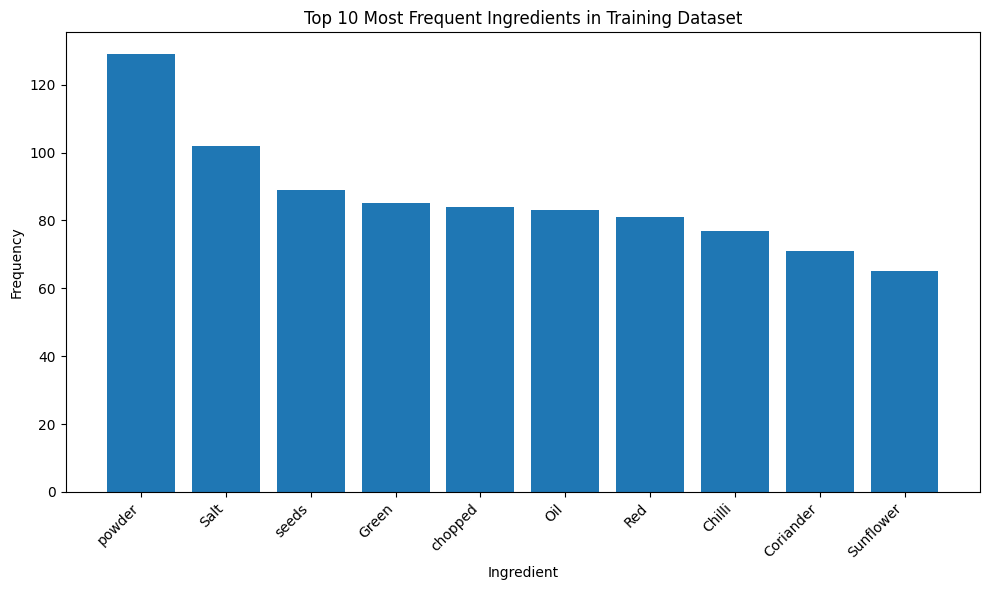

In [547]:
# # plot the top frequent ingredients in training data

# 1. The bar plots for ingredients and units provide valuable insights into the training dataset.

# 2. The most frequent ingredients and units used in recipes, which can be useful for understanding the overall composition of the data.

# 3. This information can also help identify potential biases or imbalances in the dataset, such as if certain ingredients or units are overrepresented compared to others.

# 4. Observing the frequency of different items can be helpful for feature engineering and model development.

# Plot the top 10 most frequent ingredients and units in the training data
plot_top_items(top_ingredients, 'Ingredient', dataset_name)

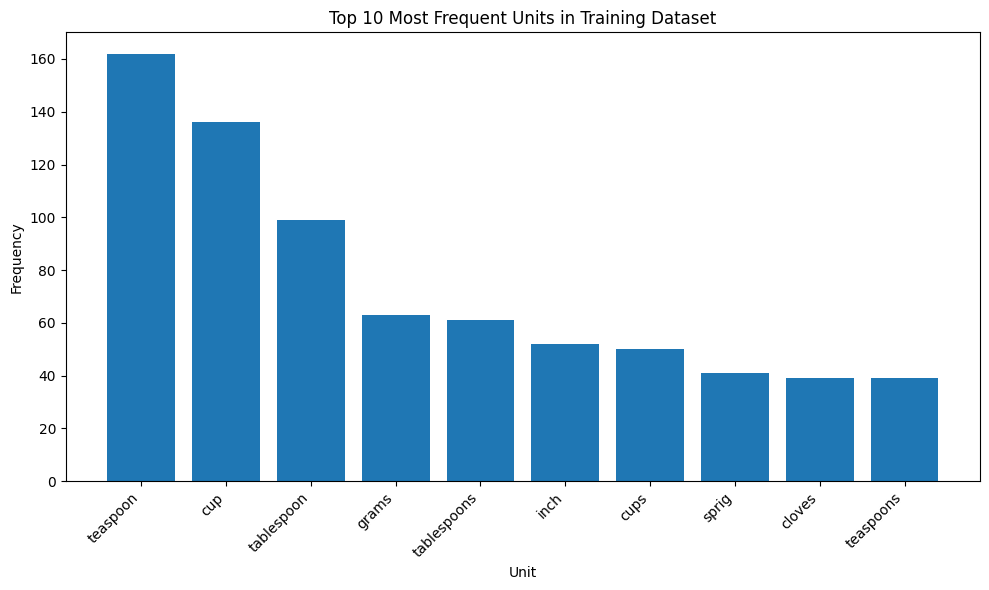

In [548]:
# plot the top frequent units in training data
plot_top_items(top_units, 'Unit', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [549]:
# initialise the dataset_name
dataset_name = 'Validation'

In [550]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


# Extract tokens and POS tags for the validation dataset
extract_and_validate_tokens(val_df, dataset_name)

# Categorize tokens for the validation dataset
all_input_tokens_val = flatten_list(val_df['input_tokens'].tolist())
all_pos_tokens_val = flatten_list(val_df['pos_tokens'].tolist())
ingredients_val, units_val, quantities_val = categorize_tokens(all_input_tokens_val, all_pos_tokens_val)

# Get the top 10 most frequent ingredients and units in the validation data
top_ingredients_val = get_top_frequent_items(ingredients_val, 'ingredient', dataset_name)
top_units_val = get_top_frequent_items(units_val, 'unit', dataset_name)


Validation Dataset:
Total number of input tokens: 2876
Total number of POS tags: 2876

First 10 input tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
First 10 POS tags: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']
Top 10 most frequent ingredients in Validation Dataset:
- powder: 54
- Salt: 47
- Oil: 39
- Red: 39
- seeds: 36
- Chilli: 36
- chopped: 31
- Green: 30
- Leaves: 29
- Coriander: 27
Top 10 most frequent units in Validation Dataset:
- teaspoon: 59
- cup: 57
- tablespoon: 32
- tablespoons: 32
- cups: 24
- sprig: 21
- inch: 20
- grams: 19
- teaspoons: 18
- cloves: 16


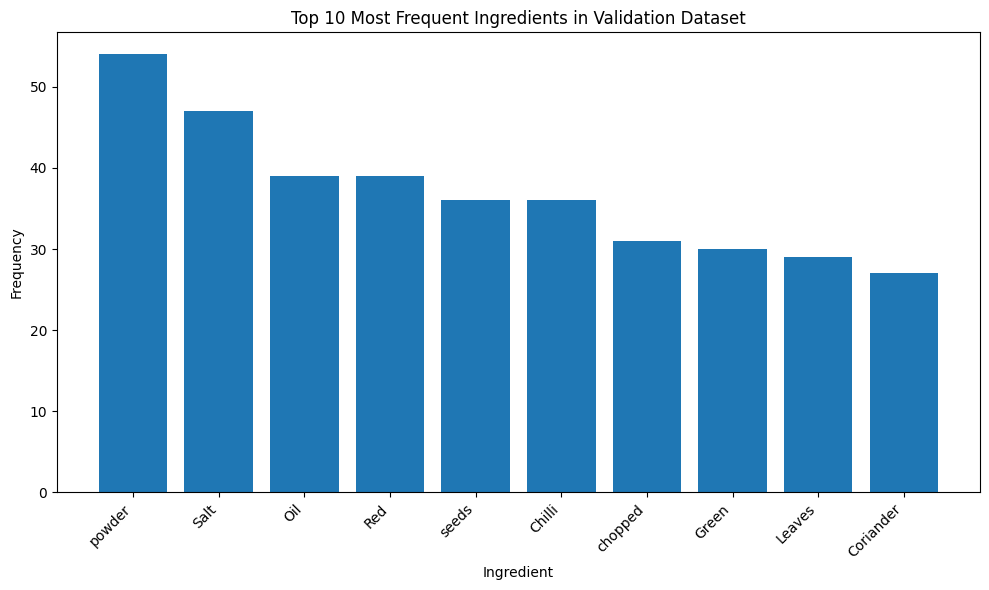

In [551]:
# plot the top frequent ingredients in validation data

# Plot the top frequent ingredients in validation data
plot_top_items(top_ingredients_val, 'Ingredient', dataset_name)


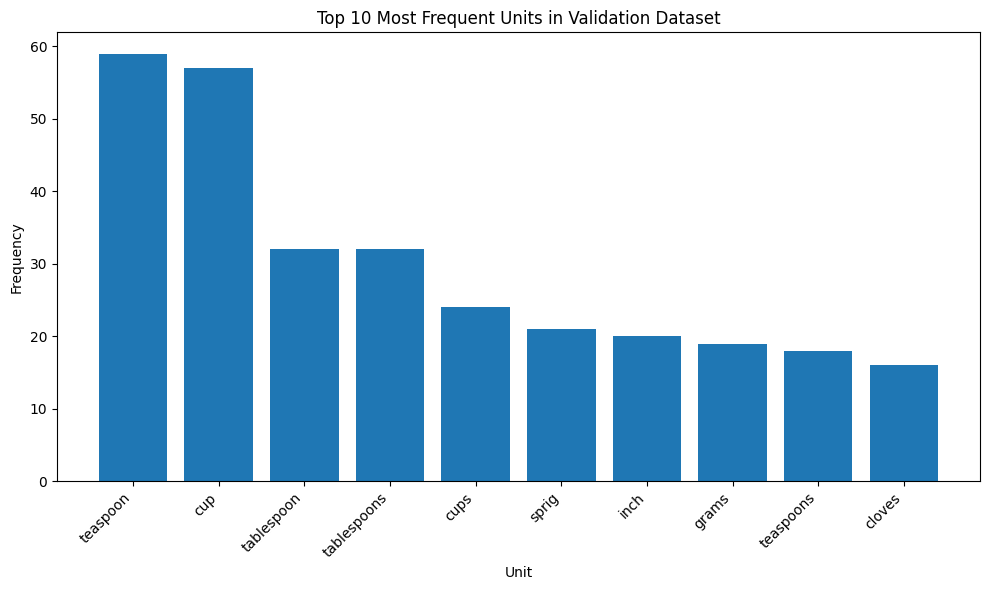

In [552]:
# plot the top frequent units in training data

# Plot the top frequent units in validation data
plot_top_items(top_units_val, 'Unit', dataset_name)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [553]:
# define unit and quantity keywords along with quantity pattern
# Define unit and quantity keywords
unit_keywords = {"cup", "tbsp", "tsp", "oz", "ml", "liter", "g", "kg", "pound", "ounce", "liter", "cl"}
quantity_keywords = {"half", "quarter", "third", "two", "one", "one-half", "one-quarter", "three", "four"}

# 2. Define the regex pattern for matching quantities like fractions, numbers, and decimals
quantity_pattern = r"(\d+/\d+|\d+\.\d+|\d+|\d+\s+?\d+/\d+|\d+\s+\d+\.\d+)"

In [554]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

# Combined pattern for mixed fractions, hiphen compounds and slash-compounds
custom_token_match = re.compile(r"""
    ^\d+-\d+/\d+$           |  # 1-1/2, 3-3/4
    ^\d+-\d+$               |  # 2-3, 10-20
    ^[A-Za-z]+/[A-Za-z]+$   |  # Pods/Seeds, Salt/Sugar
    ^[A-Za-z]+-[A-Za-z]+$      # tomato-puree
""", re.VERBOSE)

# Set the token_match rule
nlp.tokenizer.token_match = custom_token_match.match

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [555]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

def word2features(sentence, i):
    """
    Extract token-level features for CRF training, capturing core features,
    quantity and unit detection, and contextual information for a given token
    in the sentence.

    Args:
        sentence (list): List of tokens (words) in the sentence.
        i (int): Index of the current token in the sentence.

    Returns:
        dict: Feature dictionary for the token at index i in the sentence.
    """
    features = {}

    # --- Process the entire sentence with spaCy ---
    word = sentence[i]
    doc = nlp(word)
    lemma = doc[0].lemma_  # Lemmatized form of the word
    pos = doc[0].pos_  # POS tag
    tag = doc[0].tag_  # Detailed POS tag
    dep = doc[0].dep_  # Dependency relation
    shape = doc[0].shape_  # Token shape (e.g., "Xxx" for "Milk")

    # --- Core Features ---
    features["bias"] = 1.0
    features["token"] = word.lower()
    features["lemma"] = lemma.lower()
    features["pos_tag"] = pos
    features["tag"] = tag
    features["dep"] = dep
    features["shape"] = shape
    features["is_stop"] = word.lower() in nlp.Defaults.stop_words
    features["is_digit"] = word.isdigit()
    features["has_digit"] = any(char.isdigit() for char in word)
    features["has_alpha"] = any(char.isalpha() for char in word)
    features["hyphenated"] = '-' in word
    features["slash_present"] = '/' in word
    features["is_title"] = word.istitle()
    features["is_upper"] = word.isupper()
    features["is_punct"] = word in ",.!?;:"

    # --- Improved Quantity & Unit Detection ---
    features["is_quantity"] = bool(re.match(quantity_pattern, word))
    features["is_unit"] = word.lower() in unit_keywords
    features["is_numeric"] = word.isdigit()
    features["is_fraction"] = bool(re.match(r"\d+/\d+", word))
    features["is_decimal"] = bool(re.match(r"\d+\.\d+", word))

    # --- Contextual Features ---
    if i > 0:
        prev_token = sentence[i - 1]
        prev_doc = nlp(prev_token)
        prev_is_quantity = bool(re.match(quantity_pattern, prev_token))
        prev_is_digit = prev_token.isdigit()
    else:
        prev_token = "<BOS>"  # Beginning of sequence
        prev_is_quantity = False
        prev_is_digit = False

    if i < len(sentence) - 1:
        next_token = sentence[i + 1]
        next_doc = nlp(next_token)
        next_is_unit = next_token.lower() in unit_keywords
        next_is_ingredient = not (next_token.lower() in unit_keywords or bool(re.match(quantity_pattern, next_token)))
    else:
        next_token = "<EOS>"  # End of sequence
        next_is_unit = False
        next_is_ingredient = False

    # Add contextual features to the dictionary
    features["prev_token"] = prev_token.lower()
    features["prev_is_quantity"] = prev_is_quantity
    features["prev_is_digit"] = prev_is_digit
    features["BOS"] = (i == 0)  # Beginning of sequence
    features["next_token"] = next_token.lower()
    features["next_is_unit"] = next_is_unit
    features["next_is_ingredient"] = next_is_ingredient
    features["EOS"] = (i == len(sentence) - 1)  # End of sequence

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [556]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent):
    """
    Extracts features for all tokens in a sentence.

    Args:
        sent: The sentence as a list of tokens.

    Returns:
        A list of feature dictionaries, one for each token in the sentence.
    """
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [557]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

# Convert input sentences into feature sets
X_train_features = [sent2features(s) for s in X_train]
X_val_features = [sent2features(s) for s in X_val]

In [558]:
# Get labels (POS tags) from the dataframe
def get_labels(df):
    labels_list = []
    for _, row in df.iterrows():
        pos_tags = row['pos_tokens']  # Extract the list of POS tags for each row
        labels_list.append(pos_tags)  # Append to the labels list
    return labels_list

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [559]:
# Convert labels into list as y_train_labels and y_val_labels

y_train_labels = y_train
y_val_labels = y_val

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [560]:
# print the length of train features and labels

print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))

Length of X_train_features: 196
Length of y_train_labels: 196


In [561]:
# print the length of validation features and labels

print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

Length of X_val_features: 84
Length of y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [562]:
# Flatten labels in y_train

y_train_flat = [label for sublist in y_train_labels for label in sublist]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [563]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts


label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())
print("Label Count:\n", label_counts)
print("\nTotal Samples:", total_samples)

Label Count:
 Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})

Total Samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [564]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

weight_dict = {label: total_samples / count for label, count in label_counts.items()}
print("Class weights:", weight_dict)

Class weights: {'quantity': 7.259183673469388, 'unit': 8.771886559802713, 'ingredient': 1.336464399774563}


In [565]:
# penalise ingredient label

# Penalize 'ingredient' label (adjust penalty factor as needed)
penalty_factor = 0.25   # multiply with .5 or 0.25. need to reduce the weight of the ingredient
weight_dict['ingredient'] *= penalty_factor

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [566]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Extracts features and applies class weights to each token in the input data.

    Parameters:
        X (pd.Series): Series of input token lists (e.g., input_tokens).
        y (pd.Series): Series of corresponding POS label lists (e.g., pos_tokens).
        weight_dict (dict): Dictionary mapping labels to inverse frequency weights.

    Returns:
        X_features (List[List[dict]]): Feature dictionaries for each token.
        y_labels (List[List[str]]): Original labels.
        sample_weights (List[List[float]]): Weights for each token based on labels.
    """
    X_features = []
    y_labels = []
    sample_weights = []

    for sentence_tokens, label_sequence in zip(X, y):
        features = sent2features(sentence_tokens)
        weights = [weight_dict.get(label, 1.0) for label in label_sequence]  # Default weight 1.0 if label not in dict

        X_features.append(features)
        y_labels.append(label_sequence)
        sample_weights.append(weights)

    return X_features, y_labels, sample_weights

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [567]:
# Apply manually computed class weights
X_train_weighted_features, y_train_wt_labels, train_sample_weights = extract_features_with_class_weights(
    train_df['input_tokens'], train_df['pos_tokens'], weight_dict)

X_val_weighted_features, y_val_wt_labels, val_sample_weights = extract_features_with_class_weights(
    val_df['input_tokens'], val_df['pos_tokens'], weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [568]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data

# Initialize and train the CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train_weighted_features, y_train_wt_labels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [569]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train_weighted_features)

In [570]:
# specify the flat classification report by using training data for evaluation
print("Training Dataset")
print(flat_classification_report(y_train_wt_labels, y_train_pred))

Training Dataset
              precision    recall  f1-score   support

  ingredient       0.99      1.00      0.99      5323
    quantity       1.00      0.98      0.99       980
        unit       0.99      0.96      0.97       811

    accuracy                           0.99      7114
   macro avg       0.99      0.98      0.99      7114
weighted avg       0.99      0.99      0.99      7114



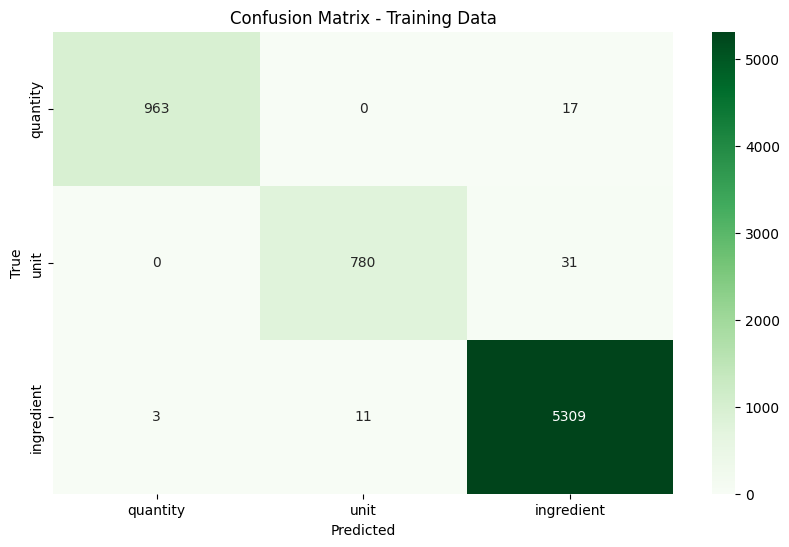

In [571]:
# create a confusion matrix on training datset

labels = list(crf.classes_)  # Get list of POS labels
cm = confusion_matrix(np.concatenate(y_train_wt_labels), np.concatenate(y_train_pred), labels=labels)
# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [572]:
# dump the model using joblib as crf_model.pkl

import datetime
# Get the current datetime
now = datetime.datetime.now()
datetime_str = now.strftime("%Y%m%d_%H%M%S")
joblib.dump(crf, f'Entities_in_Recipe_Data_crf_model{datetime_str}.pkl')

['Entities_in_Recipe_Data_crf_model20250507_170549.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [573]:
# predict the crf model on validation dataset

# Predict on the validation dataset
y_pred_val = crf.predict(X_val_weighted_features)

In [574]:
# specify flat classification report

print("Validation dataset")
# Print flat classification report for validation data
print(flat_classification_report(y_val_wt_labels, y_pred_val))

Validation dataset
              precision    recall  f1-score   support

  ingredient       0.98      1.00      0.99      2107
    quantity       0.99      0.99      0.99       411
        unit       0.98      0.91      0.94       358

    accuracy                           0.98      2876
   macro avg       0.98      0.96      0.97      2876
weighted avg       0.98      0.98      0.98      2876



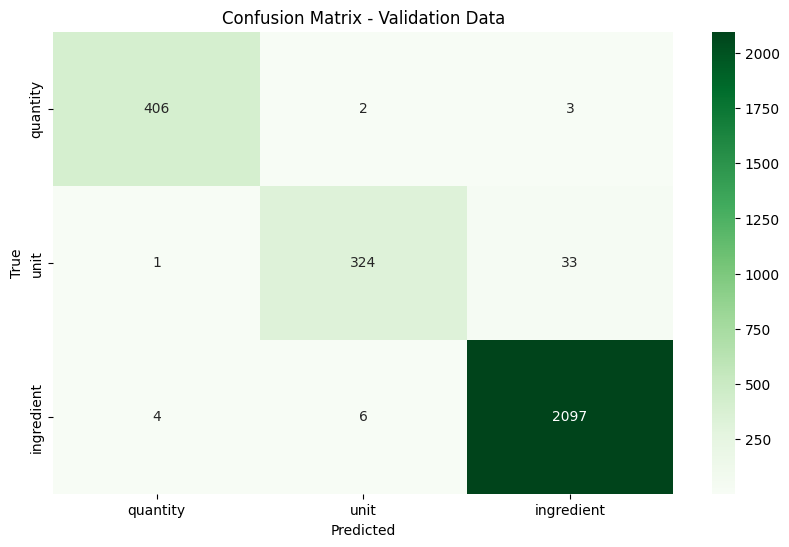

In [575]:
# create a confusion matrix on validation dataset

labels = list(crf.classes_)  # Get list of POS labels
cm = confusion_matrix(np.concatenate(y_val_wt_labels), np.concatenate(y_pred_val), labels=labels)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Validation Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [576]:
len(y_val_labels)

84

In [577]:
# flatten Labels and Initialise Error Data


# Flatten y_val_labels for analysis
y_val_flat_train = [label for sublist in y_val_wt_labels for label in sublist]
y_val_flat_pred = [label for sublist in y_pred_val for label in sublist]
# Create a list to store error data
errors = []

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [578]:
len(y_val_wt_labels)

84

In [579]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases

def collect_error_info(X_val, y_val_labels, y_pred_val):
    """
    Iterates through validation data, compares true vs. predicted labels,
    and collects error details into error_data.
    Args:
        X_val: Validation input token sequences.
        y_val_labels: True validation labels.
        y_pred_val: Predicted validation labels.
    Returns:
        List of dictionaries containing error information.
    """
    error_data = []
    for i, (tokens, true_labels, pred_labels) in enumerate(zip(X_val, y_val_labels, y_pred_val)):
        for j, (true_label, pred_label) in enumerate(zip(true_labels, pred_labels)):
            if true_label != pred_label:
                error_info = {
                    "recipe_index": i,
                    "token_index": j,
                    "token": tokens[j],
                    "true_label": true_label,
                    "pred_label": pred_label,
                    "context": tokens[max(0, j - 2):min(j + 3, len(tokens))],  # Adjust window size as needed
                    "prev_token": tokens[j - 1] if j > 0 else None,
                    "next_token": tokens[j + 1] if j < len(tokens) - 1 else None,
                }
                error_data.append(error_info)
    return error_data

# Example usage
errors = collect_error_info(X_val, y_val_labels, y_pred_val)

In [580]:
print(f"Error tokens: {len(errors)}")
print("Sample error data:", errors[:2])

Error tokens: 49
Sample error data: [{'recipe_index': 2, 'token_index': 34, 'token': 'few', 'true_label': 'ingredient', 'pred_label': 'quantity', 'context': ['Tamarind', 'Leaves', 'few'], 'prev_token': 'Leaves', 'next_token': None}, {'recipe_index': 5, 'token_index': 18, 'token': 'cloves', 'true_label': 'ingredient', 'pred_label': 'unit', 'context': ['chillies', '3', 'cloves', 'garlic', 'big'], 'prev_token': '3', 'next_token': 'garlic'}]


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [581]:
# Create DataFrame and Print Overall Accuracy
# Step1: Error dataframe
error_df = pd.DataFrame(errors)

# Step 2: Flatten the true and predicted labels for validation
y_val_true_flat = list(chain.from_iterable(y_val_labels))
y_val_pred_flat = list(chain.from_iterable(y_pred_val))

# Step 3: Calculate Accuracy
val_accuracy = accuracy_score(y_val_true_flat, y_val_pred_flat)

# Step 4: Print results
print("Validation Accuracy:", round(val_accuracy * 100, 2), "%")
print("\nSample Misclassified Tokens:")
print(error_df.head())

Validation Accuracy: 98.3 %

Sample Misclassified Tokens:
   recipe_index  token_index   token  true_label  pred_label                                 context prev_token next_token
0             2           34     few  ingredient    quantity                 [Tamarind, Leaves, few]     Leaves       None
1             5           18  cloves  ingredient        unit      [chillies, 3, cloves, garlic, big]          3     garlic
2             5           21   Spoon        unit  ingredient     [garlic, big, Spoon, oil, teaspoon]        big        oil
3             6            7  cloves        unit  ingredient  [cumin, seeds, cloves, garlic, grated]      seeds     garlic
4            12            7    gram        unit  ingredient    [Chilli, 50, gram, Spaghetti, Pasta]         50  Spaghetti


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [582]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context


# # Add a 'label_match' column for comparison
error_df['is_label_match'] = error_df['true_label'] == error_df['pred_label']

# Group by true label to calculate per-label accuracy
label_accuracy = (
    error_df.groupby('true_label')['is_label_match']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'correct', 'count': 'total'})
)
label_accuracy['accuracy (%)'] = (label_accuracy['correct'] / label_accuracy['total'] * 100).round(2)

# Add class weights to the accuracy DataFrame
label_accuracy['class_weight'] = label_accuracy.index.map(weight_dict)

# Sort by accuracy
label_accuracy = label_accuracy.sort_values(by='accuracy (%)')

# Print summary
print("🔍 Analysis - Label Error:\n")
print(label_accuracy)

# Show error sample with context
error_cols = ['token', 'prev_token', 'next_token', 'true_label', 'pred_label', 'context']
# Display what columns are actually available
print("\nColumns in error_data:\n", error_df.columns.tolist())

# Define only columns that exist
available_cols = [col for col in error_df.columns]

# Display sample errors
print("Sample Errors with Context:\n")
print(error_df[~error_df['is_label_match']][available_cols].head(10))

🔍 Analysis - Label Error:

            correct  total  accuracy (%)  class_weight
true_label                                            
ingredient        0     10           0.0      0.334116
quantity          0      5           0.0      7.259184
unit              0     34           0.0      8.771887

Columns in error_data:
 ['recipe_index', 'token_index', 'token', 'true_label', 'pred_label', 'context', 'prev_token', 'next_token', 'is_label_match']
Sample Errors with Context:

   recipe_index  token_index   token  true_label  pred_label                                   context prev_token   next_token  is_label_match
0             2           34     few  ingredient    quantity                   [Tamarind, Leaves, few]     Leaves         None           False
1             5           18  cloves  ingredient        unit        [chillies, 3, cloves, garlic, big]          3       garlic           False
2             5           21   Spoon        unit  ingredient       [garlic, big, Spoon, o

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font></br>
  <font color = red>1. Confusion between Labels - Ingredient and Quantity exists and thus labels got incorrect identified. For example, Label 'few' should be identified from context of Ingredient but identified as QUantity </font></br>
  <font color = red>2. Confusion between Lables - Ingredient and Unit exists while identifying labels. For example, Cloves should be seen as Ingredient, when appearing with a numeric quantity identified as Unit</font></br>
 <font color = red>3. Visualize section provides frequency of each category and most frequent items</br></font>
<font color = red>4. Top 10 most frequent ingredients in Validation Dataset:
- powder: 54
- Salt: 47
- Oil: 39
- Red: 39
- seeds: 36
- Chilli: 36
- chopped: 31
- Green: 30
- Leaves: 29
- Coriander: 27</font></br>
<font color = red>5. Top 10 most frequent units in Validation Dataset:
- teaspoon: 59
- cup: 57
- tablespoon: 32
- tablespoons: 32
- cups: 24
- sprig: 21
- inch: 20
- grams: 19
- teaspoons: 18
- cloves: 16 </font></br>



## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.
